In [1]:
from modules.DLA_model import Diffusion, compare_omegas, plot_omega_comparison
from joblib import Parallel, delayed
import numpy as np

## Test various $\eta$

We test 3 values of $\eta$, $0, 1, 2$, run $200$ growth iterations and the default value of $\omega = 1.8$.

We plot the resulting cluster and concentration of the grid cells.

Disclamer: execution of the following cell takes around 6 minutes.

In [ ]:
grid_size = 100
growth_iterations = 200

def run_simulation_and_plot(eta):
    diffusion = Diffusion(grid_size, eta, initial_point="bottom")
    diffusion.run_simulation(growth_iterations)
    diffusion.plot(eta, save=True, filename=f"diffusion_eta_{eta}_200.png")

_ = Parallel(n_jobs=-2)(
        delayed(run_simulation_and_plot)(eta) for eta in [0, 1, 2]
    )

## Find optimal value of $\omega$

Next, we try to find the approximate optimal value of $\omega$ for the three values of $\eta = 0, 1, 2$.

We start with initial guess of $\omega = 1.4, 1.6, 1.8, 1.9$ and run $20$ simulations with $50$ growth iterations for each combination of $\omega$ and $\eta$.

During each growth step, we solve the Lapsal equation using the SOR method and we check the number of iterations we had to do for SOR to converge. We then measure the performance of each $\omega$ by checking the total number of iterations we had to do in SOR and plot the results.

Disclamer: execution of each of the three following cells can take up to 30 minutes.


30 simulations
15 min

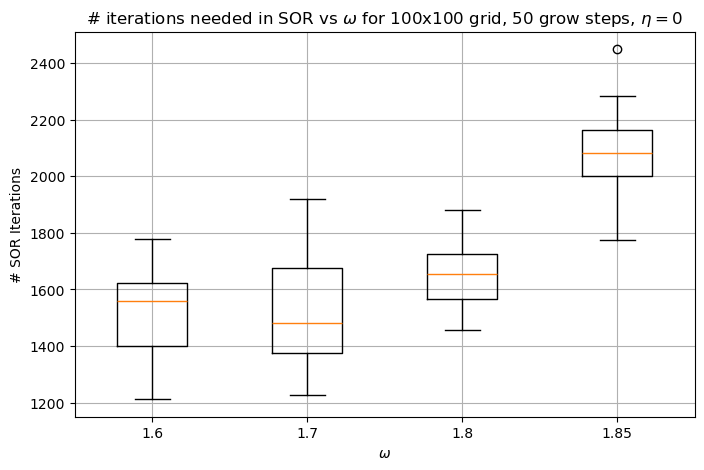

In [2]:
eta = 0
omegas = [1.6, 1.7, 1.8, 1.85]
num_simulations = 30

results_omegas_eta_0 = compare_omegas(eta, omegas, num_simulations)
plot_omega_comparison(results_omegas_eta_0, omegas, eta, save=True, filename="omega_comparison_eta_0.png")

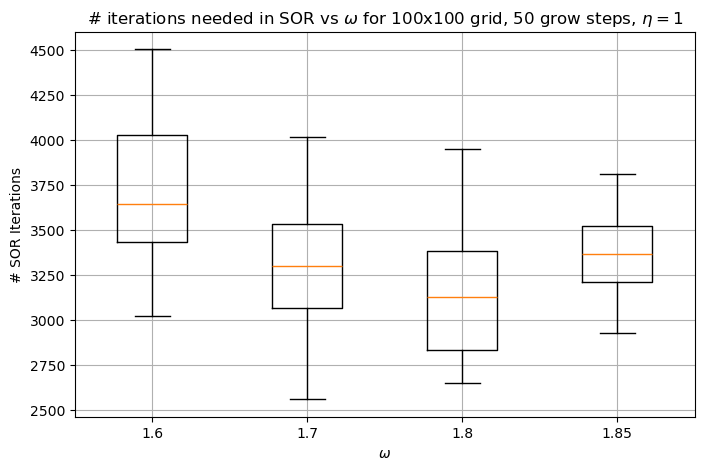

In [4]:
eta = 1
omegas = [1.6, 1.7, 1.8, 1.85]
num_simulations = 30

results_omegas_eta_1 = compare_omegas(eta, omegas, num_simulations)
plot_omega_comparison(results_omegas_eta_1, omegas, eta, save=True, filename="omega_comparison_eta_1.png")

In [ ]:
eta = 2
omegas = [1.6, 1.7, 1.8, 1.85]
num_simulations = 30

results_omegas_eta_2 = compare_omegas(eta, omegas, num_simulations)
plot_omega_comparison(results_omegas_eta_2, omegas, eta, save=True, filename="omega_comparison_eta_2.png")

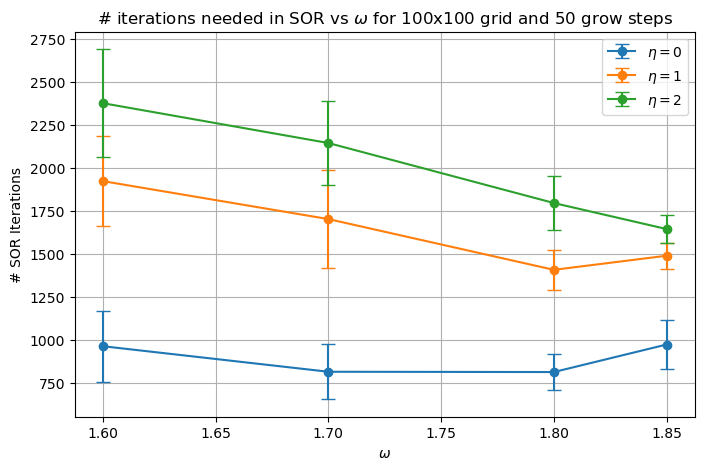

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

means_0 = np.mean(np.array(results_omegas_eta_0), axis=0)
stds_0 = np.std(np.array(results_omegas_eta_0), axis=0)

means_1 = np.mean(np.array(results_omegas_eta_1), axis=0)
stds_1 = np.std(np.array(results_omegas_eta_1), axis=0)

means_2 = np.mean(np.array(results_omegas_eta_2), axis=0)
stds_2 = np.std(np.array(results_omegas_eta_2), axis=0)

plt.figure(figsize=(8, 5))
plt.errorbar(omegas, means_0, yerr=stds_0, fmt='o-', capsize=5, label=r'$\eta = 0$')
plt.errorbar(omegas, means_1, yerr=stds_1, fmt='o-', capsize=5, label=r'$\eta = 1$')
plt.errorbar(omegas, means_2, yerr=stds_2, fmt='o-', capsize=5, label=r'$\eta = 2$')
plt.xlabel(r'$\omega$')
plt.ylabel('# SOR Iterations')
plt.title(r'# iterations needed in SOR vs $\omega$ for 100x100 grid and 50 grow steps')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig("omega_vs_sor_mean.png", dpi=300, bbox_inches='tight')

Given the results from above, we redefine our guesses for $\omega$ and simulate again.

Disclaimer: execution of each of the three following cells can take up to 15 minutes.

In [ ]:
eta = 0
omegas = [1.4, 1.6, 1.8]
num_simulations = 1

results = compare_omegas(eta, omegas, num_simulations)
plot_omega_comparison(results, omegas, eta, save=True, filename="omega_comparison_eta_0_v2.png")

In [ ]:
eta = 1
omegas = [1.75, 1.8, 1.85]
num_simulations = 20

results = compare_omegas(eta, omegas, num_simulations)
plot_omega_comparison(results, omegas, eta, save=True, filename="omega_comparison_eta_1_v2.png")

In [ ]:
eta = 2
omegas = [1.8, 1.85, 1.9]
num_simulations = 20

results = compare_omegas(eta, omegas, num_simulations)
plot_omega_comparison(results, omegas, eta, save=True, filename="omega_comparison_eta_2.png")

## Analysing the cluster shape

Lastly, we analyse the shape of the cluster so that we can compare it to the Monte Carlo simulation. 

Again, for three values of $\eta = 0, 1, 2$ and $200$ growth steps, we run $20$ simulations each and measure the size of the perimeter and the width and height of the cluster. We then plot our results. We use the optimal $\omega$ for each $\eta$ found in the previous part.

Disclamer: execution of each of the three following cells can take up to

In [ ]:
grid_size = 100
growth_iterations = 200
num_simulations = 20

def run_simulation_and_measure(eta, omega):
    diffusion = Diffusion(grid_size, eta, initial_point="bottom")
    diffusion.run_simulation(growth_iterations, omega)

    return [diffusion.get_perimeter_size(), diffusion.get_width(), diffusion.get_height()]

In [ ]:
eta = 0
omega = 1.6

clusters_eta_0 = Parallel(n_jobs=-2)(
        delayed(run_simulation_and_measure)(eta, omega) for _ in range(num_simulations)
    )

clusters_eta_0 = np.array(clusters_eta_0)

print(f"The average perimeter size for cluster size {grid_size} and η = {eta} is {np.mean([cluster[0] for cluster in clusters_eta_0])}")
print(f"The average width for cluster size {grid_size} and η = {eta} is {np.mean([cluster[1] for cluster in clusters_eta_0])}")
print(f"The average height for cluster size {grid_size} and η = {eta} is {np.mean([cluster[2] for cluster in clusters_eta_0])}")

In [ ]:
eta = 1
omega = 1.8

clusters_eta_1 = Parallel(n_jobs=-2)(
        delayed(run_simulation_and_measure)(eta, omega) for _ in range(num_simulations)
    )

clusters_eta_1 = np.array(clusters_eta_1)

print(f"The average perimeter size for cluster size {grid_size} and η = {eta} is {np.mean([cluster[0] for cluster in clusters_eta_1])}")
print(f"The average width for cluster size {grid_size} and η = {eta} is {np.mean([cluster[1] for cluster in clusters_eta_1])}")
print(f"The average height for cluster size {grid_size} and η = {eta} is {np.mean([cluster[2] for cluster in clusters_eta_1])}")

In [ ]:
eta = 2
omega = 1.8

clusters_eta_2 = Parallel(n_jobs=-2)(
        delayed(run_simulation_and_measure)(eta, omega) for _ in range(num_simulations)
    )

clusters_eta_2 = np.array(clusters_eta_2)

print(f"The average perimeter size for cluster size {grid_size} and η = {eta} is {np.mean([cluster[0] for cluster in clusters_eta_2])}")
print(f"The average width for cluster size {grid_size} and η = {eta} is {np.mean([cluster[1] for cluster in clusters_eta_2])}")
print(f"The average height for cluster size {grid_size} and η = {eta} is {np.mean([cluster[2] for cluster in clusters_eta_2])}")